In [1]:
#import Nesscery Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report,confusion_matrix

# deep learning libraries

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout

In [1]:
#insert the folder path train and test

train_path="data/train"
test_path="data/test"

In [5]:
# Initialize ImageDataGenerator with data augmentation settings

gen=ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

In [7]:
# train generators

train_generator=gen.flow_from_directory(
    train_path,
    subset='training',
    color_mode='rgb',
    class_mode='categorical',
    target_size=(224,224),
    batch_size=32,
    shuffle=True,
    seed=42
)

Found 4984 images belonging to 11 classes.


In [9]:
#validation generators

validation_generator=gen.flow_from_directory(
    train_path,
    subset='validation',
    color_mode='rgb',
    class_mode='categorical',
    target_size=(224,224),
    batch_size=32,
    shuffle=True,
    seed=42
)

Found 1241 images belonging to 11 classes.


In [11]:
# it gives the next value of an iteration

x,y=next(train_generator)

In [62]:
x.shape

(32, 224, 224, 3)

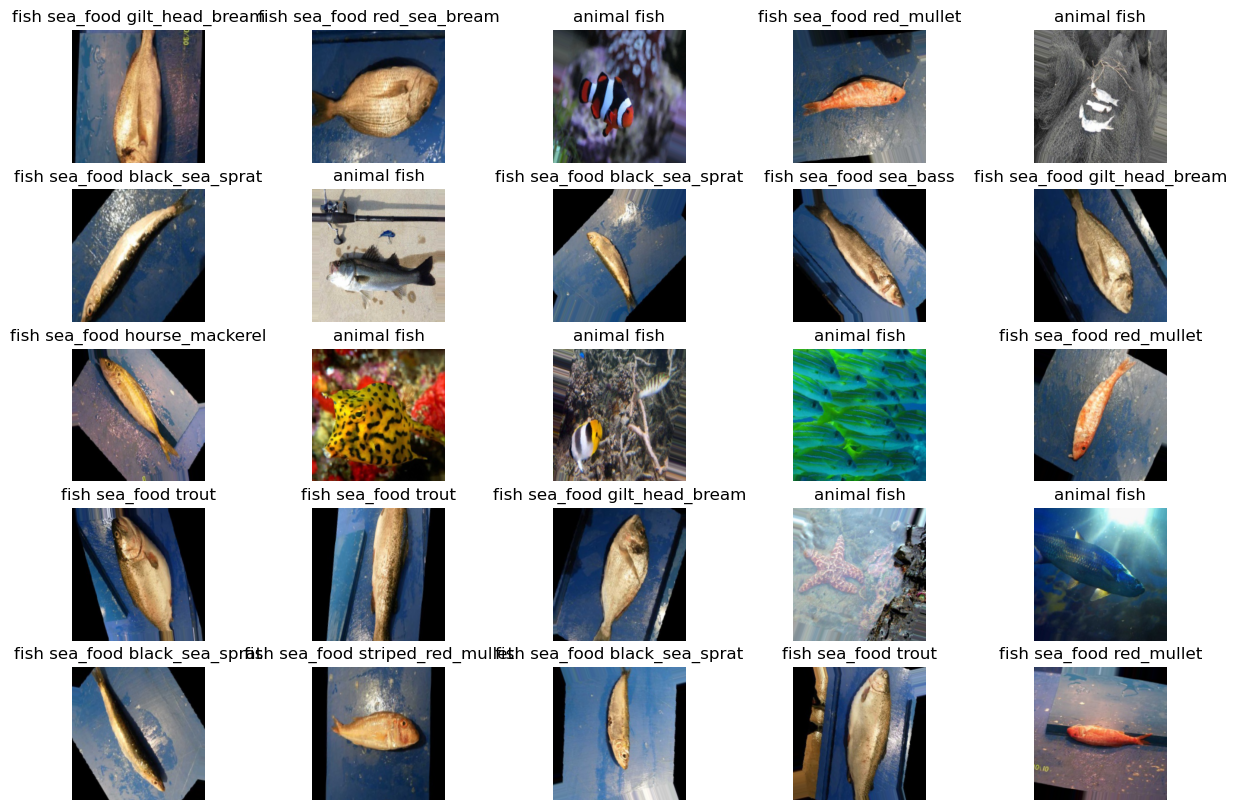

In [64]:
# plotting image from train dataset

a = train_generator.class_indices
class_names = list(a.keys()) # storing the class/breed names in a list

def plot_images(img,labels):
  plt.figure(figsize=[15,10])
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(img[i])
    plt.title(class_names[labels[i].argmax()])
    plt.axis('off')

plot_images(x,y)

In [ ]:
#Apply the pre-trained model "VGG16" 

In [66]:
from tensorflow.keras.applications import VGG16

In [68]:
# building our model using pre-trained Model "VGG16"

base_model = VGG16(
    include_top=False,# Customize the output layers for your specific classification task.
    weights='imagenet',#Loads weights from a model trained on the large ImageNet dataset.
    input_shape=(224,224,3)
)

base_model.trainable = False # freeze the base model

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax')
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 294s 5us/step


In [70]:
# compile the model

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [72]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 7, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,145,035 (57.77 MB)

 Trainable params: 429,323 (1.64 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [74]:
# defining call backs to preserve the best result
#Overfiting 

early = tf.keras.callbacks.EarlyStopping(patience = 3,min_delta = 0.001,restore_best_weights = True)

In [76]:
# train the model

batch_size = 32

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

In [78]:
# fit the model

history = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=50,
    callbacks=[early]
)                                                                                                                                                                                                                       

C:\Users\vnave\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 2433s 15s/step - accuracy: 0.5621 - loss: 1.2910 - val_accuracy: 0.7064 - val_loss: 0.7883
Epoch 2/50
  1/155 ━━━━━━━━━━━━━━━━━━━━ 26:58 11s/step - accuracy: 0.9062 - loss: 0.3026

C:\Users\vnave\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


155/155 ━━━━━━━━━━━━━━━━━━━━ 430s 3s/step - accuracy: 0.9062 - loss: 0.3026 - val_accuracy: 0.7023 - val_loss: 0.7848
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 2152s 14s/step - accuracy: 0.9080 - loss: 0.2826 - val_accuracy: 0.9276 - val_loss: 0.2447
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 447s 3s/step - accuracy: 1.0000 - loss: 0.1067 - val_accuracy: 0.9194 - val_loss: 0.2485
Epoch 5/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 2136s 14s/step - accuracy: 0.9352 - loss: 0.1944 - val_accuracy: 0.9564 - val_loss: 0.1295
Epoch 6/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 425s 3s/step - accuracy: 1.0000 - loss: 0.0976 - val_accuracy: 0.9564 - val_loss: 0.1212
Epoch 7/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 2125s 14s/step - accuracy: 0.9497 - loss: 0.1659 - val_accuracy: 0.9663 - val_loss: 0.1083
Epoch 8/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 427s 3s/step - accuracy: 0.9688 - loss: 0.1420 - val_accuracy: 0.9712 - val_loss: 0.1040
Epoch 9/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 2142s 14s/step - accuracy: 0.9560 - loss: 0.1402 - val_accurac

In [80]:
# store results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


In [82]:
# evalutae the accuracy of the model and Loss

accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print('Accuracy : {:.2f}%'.format(accuracy_score[1]*100))
#Converts the accuracy value to a percentage and prints it to two decimal places.
print('Loss:',accuracy_score[0])

# accuracy_score[0] will hold the loss value.
# accuracy_score[1] will hold the accuracy value.

39/39 ━━━━━━━━━━━━━━━━━━━━ 468s 12s/step - accuracy: 0.9720 - loss: 0.0788
[0.0698622539639473, 0.9726027250289917]
Accuracy : 97.26%
Loss: 0.0698622539639473


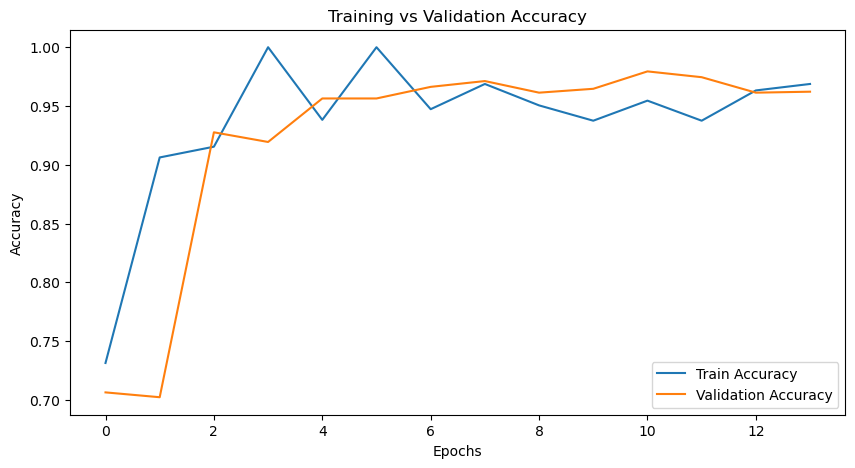

In [84]:
# Plot training & validation accuracy

plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

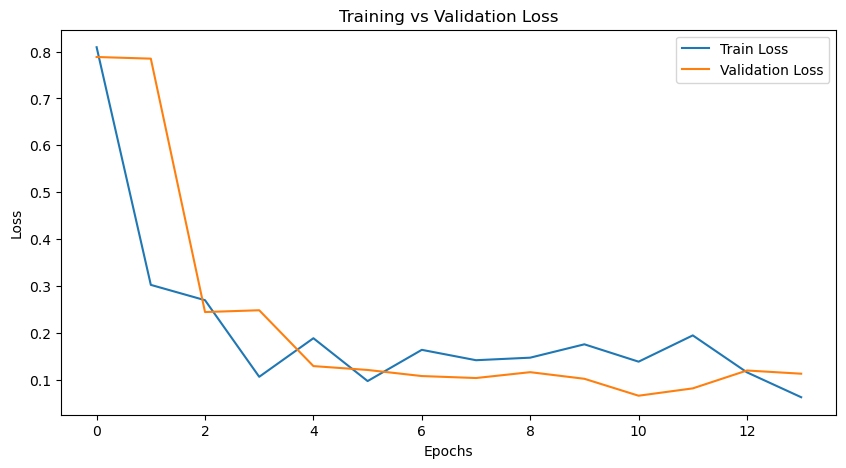

In [86]:
# Plot training & validation loss

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [90]:
test_gen = ImageDataGenerator(rescale=1./255)

In [92]:
test_iter = test_gen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    class_mode=None,   # because no labels in test set
    shuffle=False,     # keeps order so predictions map to filenames
    batch_size=32
)


Found 3187 images belonging to 11 classes.


In [94]:
# Predictions
y_pred = model.predict(test_iter)

# Convert probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels from the generator
y_true = test_iter.classes

100/100 ━━━━━━━━━━━━━━━━━━━━ 1157s 12s/step


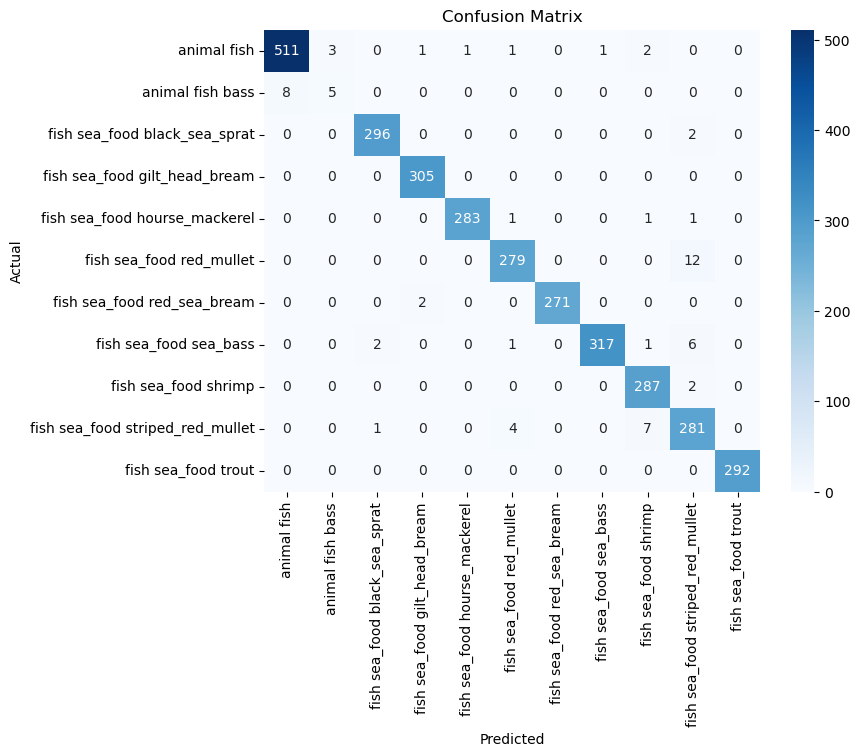

In [96]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_iter.class_indices.keys(),
            yticklabels=test_iter.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [98]:
report = classification_report(y_true, y_pred_classes,
                               target_names=test_iter.class_indices.keys())
print(report)


                                  precision    recall  f1-score   support

                     animal fish       0.98      0.98      0.98       520
                animal fish bass       0.62      0.38      0.48        13
   fish sea_food black_sea_sprat       0.99      0.99      0.99       298
   fish sea_food gilt_head_bream       0.99      1.00      1.00       305
   fish sea_food hourse_mackerel       1.00      0.99      0.99       286
        fish sea_food red_mullet       0.98      0.96      0.97       291
     fish sea_food red_sea_bream       1.00      0.99      1.00       273
          fish sea_food sea_bass       1.00      0.97      0.98       327
            fish sea_food shrimp       0.96      0.99      0.98       289
fish sea_food striped_red_mullet       0.92      0.96      0.94       293
             fish sea_food trout       1.00      1.00      1.00       292

                        accuracy                           0.98      3187
                       macro avg    

In [108]:
#Save the VGG16 Model .h5 file format 

model.save("VGG16_Model.h5")

In [ ]:
#Apply the pre-trained model "ResNet50" 

In [18]:
from tensorflow.keras.applications import ResNet50

In [20]:
# building our model using pre-trained Model "ResNet50"

base_model = ResNet50(
    include_top=False,# Customize the output layers for your specific classification task.
    weights='imagenet',#Loads weights from a model trained on the large ImageNet dataset.
    input_shape=(224,224,3)
)

base_model.trainable = False # freeze the base model

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax')
])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 68s 1us/step


In [22]:
# compile the model

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 7, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,810,635 (94.65 MB)

 Trainable params: 1,218,827 (4.65 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [26]:
# defining call backs to preserve the best result
#Overfiting 

early = tf.keras.callbacks.EarlyStopping(patience = 3,min_delta = 0.001,restore_best_weights = True)

In [28]:
# train the model

batch_size = 32

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

In [30]:
# fit the model

history = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=50,
    callbacks=[early]
)                                                                                                                                                                                                                       

C:\Users\vnave\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 827s 5s/step - accuracy: 0.2725 - loss: 2.0256 - val_accuracy: 0.1579 - val_loss: 4.1663
Epoch 2/50
  1/155 ━━━━━━━━━━━━━━━━━━━━ 9:17 4s/step - accuracy: 0.3125 - loss: 1.6548

C:\Users\vnave\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


155/155 ━━━━━━━━━━━━━━━━━━━━ 151s 956ms/step - accuracy: 0.3125 - loss: 1.6548 - val_accuracy: 0.1562 - val_loss: 4.2595
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 745s 5s/step - accuracy: 0.5074 - loss: 1.3659 - val_accuracy: 0.3742 - val_loss: 1.6892
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 148s 936ms/step - accuracy: 0.4375 - loss: 1.4309 - val_accuracy: 0.3873 - val_loss: 1.6486
Epoch 5/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 752s 5s/step - accuracy: 0.5861 - loss: 1.1641 - val_accuracy: 0.6332 - val_loss: 1.0683
Epoch 6/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 148s 939ms/step - accuracy: 0.7188 - loss: 0.9029 - val_accuracy: 0.6283 - val_loss: 1.0803
Epoch 7/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 762s 5s/step - accuracy: 0.6306 - loss: 1.0814 - val_accuracy: 0.7146 - val_loss: 0.8716
Epoch 8/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.6250 - loss: 0.8962 - val_accuracy: 0.6941 - val_loss: 0.8739
Epoch 9/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 805s 5s/step - accuracy: 0.6519 - loss: 1.0053 - val_accura

In [32]:
    # store results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


In [34]:
# evalutae the accuracy of the model and Loss

accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print('Accuracy : {:.2f}%'.format(accuracy_score[1]*100))
#Converts the accuracy value to a percentage and prints it to two decimal places.
print('Loss:',accuracy_score[0])

# accuracy_score[0] will hold the loss value.
# accuracy_score[1] will hold the accuracy value.

39/39 ━━━━━━━━━━━━━━━━━━━━ 151s 4s/step - accuracy: 0.8106 - loss: 0.6047
[0.6125295758247375, 0.7969379425048828]
Accuracy : 79.69%
Loss: 0.6125295758247375


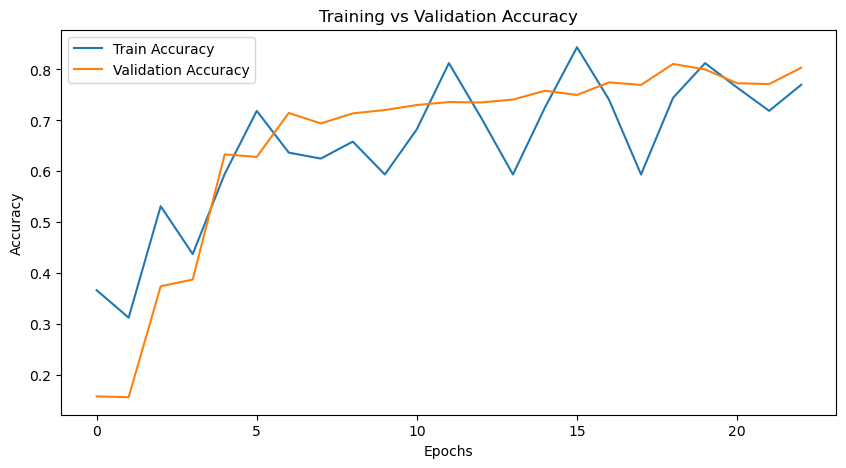

In [36]:
# Plot training & validation accuracy

plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

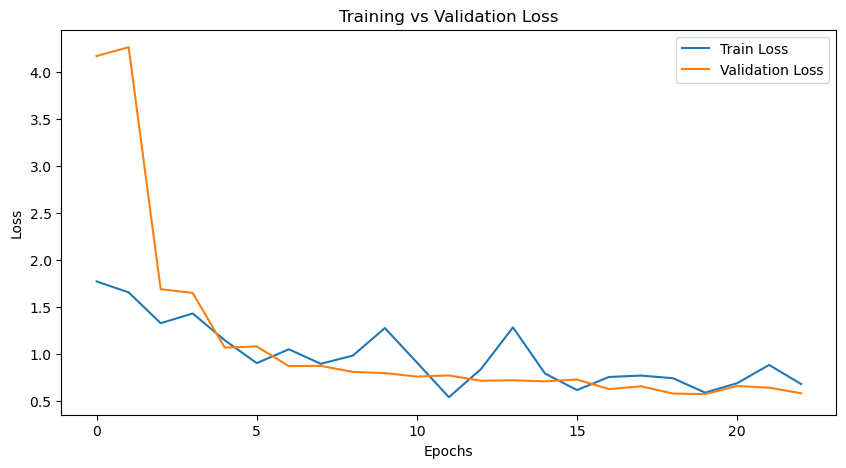

In [38]:
# Plot training & validation loss

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [40]:
test_gen = ImageDataGenerator(rescale=1./255)

In [42]:
test_iter = test_gen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    class_mode=None,   # because no labels in test set
    shuffle=False,     # keeps order so predictions map to filenames
    batch_size=32
)


Found 3187 images belonging to 11 classes.


In [44]:
# Predictions
y_pred = model.predict(test_iter)

# Convert probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels from the generator
y_true = test_iter.classes

100/100 ━━━━━━━━━━━━━━━━━━━━ 386s 4s/step


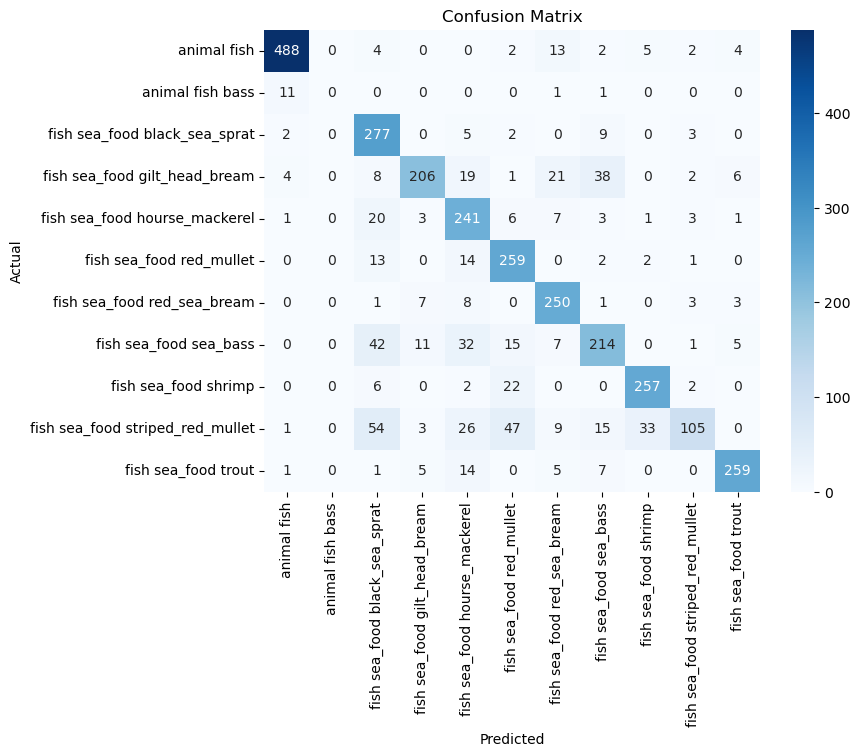

In [46]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_iter.class_indices.keys(),
            yticklabels=test_iter.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [48]:
report = classification_report(y_true, y_pred_classes,
                               target_names=test_iter.class_indices.keys())
print(report)


                                  precision    recall  f1-score   support

                     animal fish       0.96      0.94      0.95       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.65      0.93      0.77       298
   fish sea_food gilt_head_bream       0.88      0.68      0.76       305
   fish sea_food hourse_mackerel       0.67      0.84      0.74       286
        fish sea_food red_mullet       0.73      0.89      0.80       291
     fish sea_food red_sea_bream       0.80      0.92      0.85       273
          fish sea_food sea_bass       0.73      0.65      0.69       327
            fish sea_food shrimp       0.86      0.89      0.88       289
fish sea_food striped_red_mullet       0.86      0.36      0.51       293
             fish sea_food trout       0.93      0.89      0.91       292

                        accuracy                           0.80      3187
                       macro avg    

C:\Users\vnave\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vnave\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vnave\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#Apply the pre-trained model "MobileNet" 

In [13]:
from tensorflow.keras.applications import MobileNet

In [15]:
# building our model using pre-trained Model "MobileNet"

base_model_MobileNet = MobileNet(
    include_top=False,# Customize the output layers for your specific classification task.
    weights='imagenet',#Loads weights from a model trained on the large ImageNet dataset.
    input_shape=(224,224,3)
)

base_model_MobileNet.trainable = False # freeze the base model

model_MobileNet = tf.keras.Sequential([
    base_model_MobileNet,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax')
])

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 22s 1us/step


In [17]:
# compile the model

model_MobileNet.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
model_MobileNet.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 7, 7, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 7, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,923,403 (14.97 MB)

 Trainable params: 692,491 (2.64 MB)

 Non-trainable params: 3,230,912 (12.32 MB)

In [21]:
# defining call backs to preserve the best result
#Overfiting 

early = tf.keras.callbacks.EarlyStopping(patience = 3,min_delta = 0.001,restore_best_weights = True)

In [23]:
# train the model

batch_size = 32

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

In [25]:
# fit the model

history_MobileNet = model_MobileNet.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=50,
    callbacks=[early]
)                                                                                                                                                                                                                       

C:\Users\vnave\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - accuracy: 0.7082 - loss: 0.9314 - val_accuracy: 0.9827 - val_loss: 0.0527
Epoch 2/50
  1/155 ━━━━━━━━━━━━━━━━━━━━ 3:37 1s/step - accuracy: 1.0000 - loss: 0.0281

C:\Users\vnave\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


155/155 ━━━━━━━━━━━━━━━━━━━━ 68s 432ms/step - accuracy: 1.0000 - loss: 0.0281 - val_accuracy: 0.9794 - val_loss: 0.0564
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.9755 - loss: 0.0810 - val_accuracy: 0.9901 - val_loss: 0.0313
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 57s 365ms/step - accuracy: 0.9688 - loss: 0.0827 - val_accuracy: 0.9910 - val_loss: 0.0259
Epoch 5/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - accuracy: 0.9752 - loss: 0.0751 - val_accuracy: 0.9844 - val_loss: 0.0720
Epoch 6/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 52s 332ms/step - accuracy: 0.9062 - loss: 0.3340 - val_accuracy: 0.9811 - val_loss: 0.0648
Epoch 7/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.9815 - loss: 0.0561 - val_accuracy: 0.9959 - val_loss: 0.0120
Epoch 8/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 54s 344ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9934 - val_loss: 0.0259
Epoch 9/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.9888 - loss: 0.0362 - val_accurac

In [27]:
    # store results

acc = history_MobileNet.history['accuracy']
val_acc = history_MobileNet.history['val_accuracy']
loss = history_MobileNet.history['loss']
val_loss = history_MobileNet.history['val_loss']


In [29]:
# evalutae the accuracy of the model and Loss

accuracy_score = model_MobileNet.evaluate(validation_generator)
print(accuracy_score)
print('Accuracy : {:.2f}%'.format(accuracy_score[1]*100))
#Converts the accuracy value to a percentage and prints it to two decimal places.
print('Loss:',accuracy_score[0])

# accuracy_score[0] will hold the loss value.
# accuracy_score[1] will hold the accuracy value.

39/39 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9963 - loss: 0.0118
[0.020959287881851196, 0.9903303980827332]
Accuracy : 99.03%
Loss: 0.020959287881851196


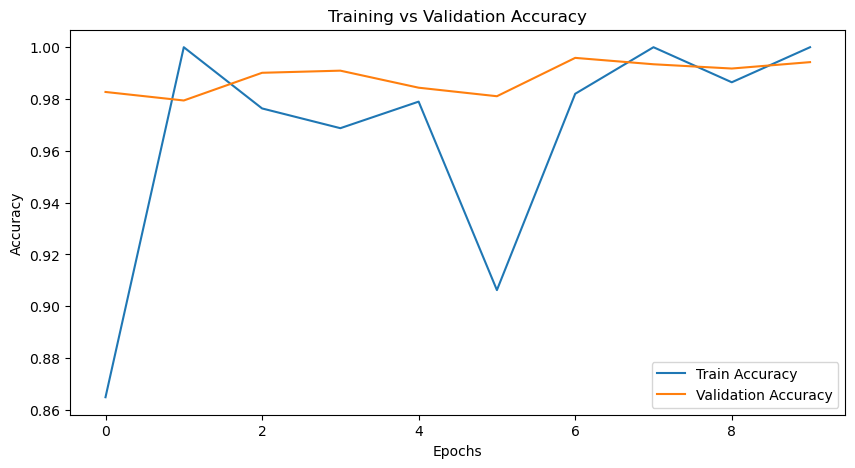

In [35]:
# Plot training & validation accuracy

plt.figure(figsize=(10,5))
plt.plot(history_MobileNet.history['accuracy'], label='Train Accuracy')
plt.plot(history_MobileNet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

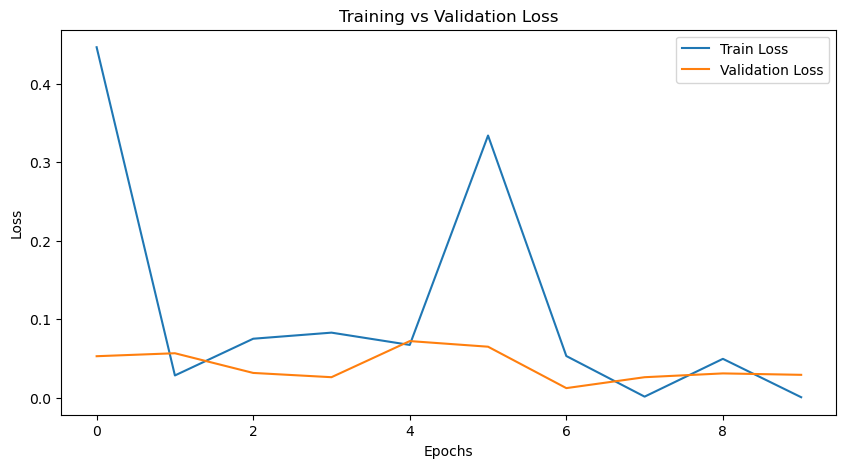

In [37]:
# Plot training & validation loss

plt.figure(figsize=(10,5))
plt.plot(history_MobileNet.history['loss'], label='Train Loss')
plt.plot(history_MobileNet.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [39]:
test_gen_mobileNet = ImageDataGenerator(rescale=1./255)

In [41]:
test_iter_mobileNet = test_gen_mobileNet.flow_from_directory(
    test_path,
    target_size=(224, 224),
    class_mode=None,   # because no labels in test set
    shuffle=False,     # keeps order so predictions map to filenames
    batch_size=32
)


Found 3187 images belonging to 11 classes.


In [45]:
# Predictions
y_pred = model_MobileNet.predict(test_iter_mobileNet)

# Convert probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels from the generator
y_true = test_iter_mobileNet.classes

100/100 ━━━━━━━━━━━━━━━━━━━━ 92s 924ms/step


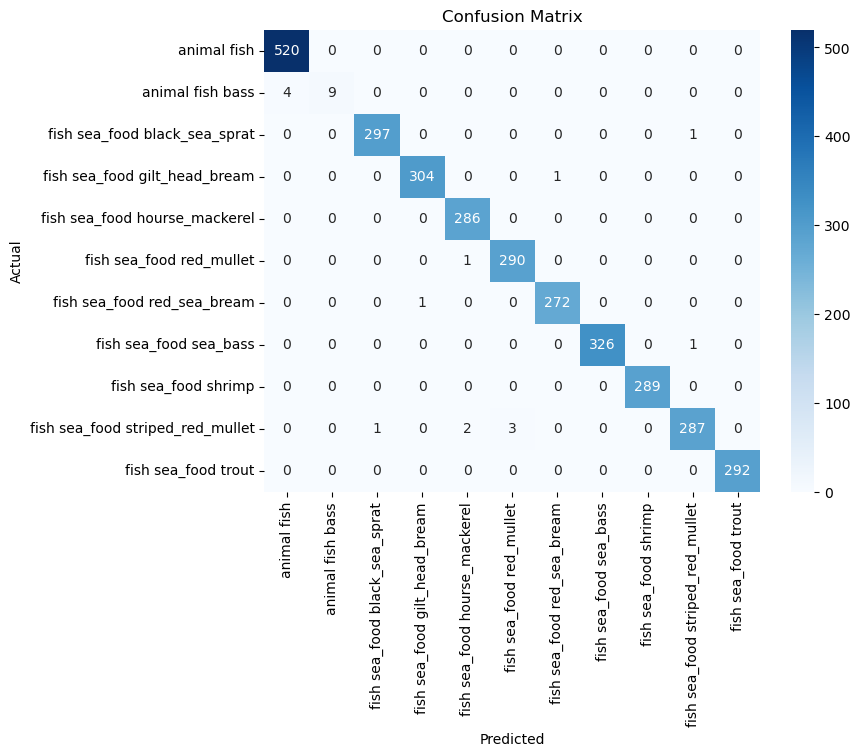

In [49]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_iter_mobileNet.class_indices.keys(),
            yticklabels=test_iter_mobileNet.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [51]:
report = classification_report(y_true, y_pred_classes,
                               target_names=test_iter_mobileNet.class_indices.keys())
print(report)


                                  precision    recall  f1-score   support

                     animal fish       0.99      1.00      1.00       520
                animal fish bass       1.00      0.69      0.82        13
   fish sea_food black_sea_sprat       1.00      1.00      1.00       298
   fish sea_food gilt_head_bream       1.00      1.00      1.00       305
   fish sea_food hourse_mackerel       0.99      1.00      0.99       286
        fish sea_food red_mullet       0.99      1.00      0.99       291
     fish sea_food red_sea_bream       1.00      1.00      1.00       273
          fish sea_food sea_bass       1.00      1.00      1.00       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       0.99      0.98      0.99       293
             fish sea_food trout       1.00      1.00      1.00       292

                        accuracy                           1.00      3187
                       macro avg    

In [53]:
#Save the MobileNet Model .h5 file format 

model_MobileNet.save("MobileNet_Model.h5")

In [ ]:
#Apply the pre-trained model "InceptionV3" 

In [55]:
from tensorflow.keras.applications import InceptionV3

In [57]:
# building our model using pre-trained Model "MobileNet"

base_model_InceptionV3 = InceptionV3(
    include_top=False,# Customize the output layers for your specific classification task.
    weights='imagenet',#Loads weights from a model trained on the large ImageNet dataset.
    input_shape=(224,224,3)
)

base_model_InceptionV3.trainable = False # freeze the base model

model_InceptionV3 = tf.keras.Sequential([
    base_model_InceptionV3,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax')
])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 128s 1us/step


In [59]:
# compile the model

model_InceptionV3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [61]:
model_InceptionV3.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_95               │ (None, 5, 5, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,025,707 (87.84 MB)

 Trainable params: 1,218,827 (4.65 MB)

 Non-trainable params: 21,806,880 (83.19 MB)

In [63]:
# defining call backs to preserve the best result
#Overfiting 

early_inceptionv3  = tf.keras.callbacks.EarlyStopping(patience = 3,min_delta = 0.001,restore_best_weights = True)

In [65]:
# train the model

batch_size = 32

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

In [67]:
# fit the model

history_InceptionV3 = model_InceptionV3.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=50,
    callbacks=[early_inceptionv3]
)                                                                                                                                                                                                                       

Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 549s 3s/step - accuracy: 0.7015 - loss: 0.9093 - val_accuracy: 0.9424 - val_loss: 0.1741
Epoch 2/50
  1/155 ━━━━━━━━━━━━━━━━━━━━ 5:47 2s/step - accuracy: 0.9688 - loss: 0.0873

C:\Users\vnave\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


155/155 ━━━━━━━━━━━━━━━━━━━━ 109s 695ms/step - accuracy: 0.9688 - loss: 0.0873 - val_accuracy: 0.9416 - val_loss: 0.1757
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 517s 3s/step - accuracy: 0.9259 - loss: 0.2399 - val_accuracy: 0.9638 - val_loss: 0.1015
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 101s 636ms/step - accuracy: 0.9375 - loss: 0.1693 - val_accuracy: 0.9539 - val_loss: 0.1384
Epoch 5/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 512s 3s/step - accuracy: 0.9426 - loss: 0.1711 - val_accuracy: 0.9688 - val_loss: 0.0955
Epoch 6/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 142s 903ms/step - accuracy: 0.9688 - loss: 0.0778 - val_accuracy: 0.9655 - val_loss: 0.0897
Epoch 7/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 509s 3s/step - accuracy: 0.9539 - loss: 0.1360 - val_accuracy: 0.9704 - val_loss: 0.0912
Epoch 8/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 102s 645ms/step - accuracy: 0.9375 - loss: 0.1688 - val_accuracy: 0.9811 - val_loss: 0.0694
Epoch 9/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 509s 3s/step - accuracy: 0.9589 - loss: 0.1242 - val_acc

In [69]:
#store results

acc = history_InceptionV3.history['accuracy']
val_acc = history_InceptionV3.history['val_accuracy']
loss = history_InceptionV3.history['loss']
val_loss = history_InceptionV3.history['val_loss']


In [71]:
# evalutae the accuracy of the model and Loss

accuracy_score = model_InceptionV3.evaluate(validation_generator)
print(accuracy_score)
print('Accuracy : {:.2f}%'.format(accuracy_score[1]*100))
#Converts the accuracy value to a percentage and prints it to two decimal places.
print('Loss:',accuracy_score[0])

# accuracy_score[0] will hold the loss value.
# accuracy_score[1] will hold the accuracy value.

39/39 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.9733 - loss: 0.0871
[0.08565513044595718, 0.9734085202217102]
Accuracy : 97.34%
Loss: 0.08565513044595718


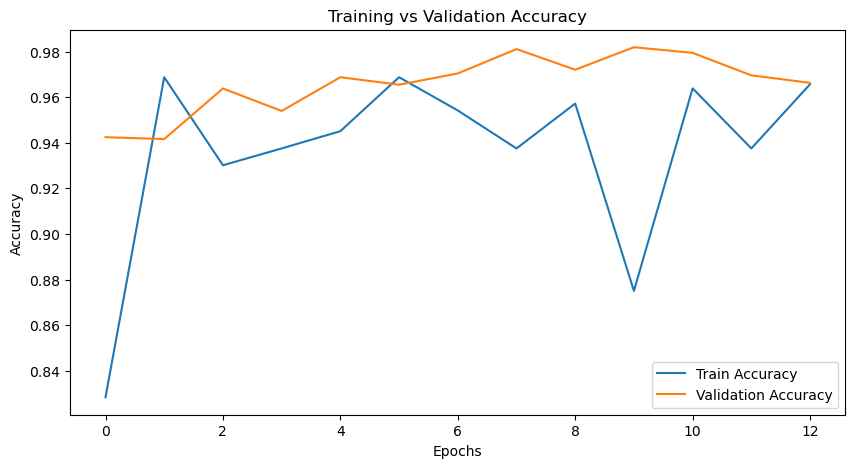

In [73]:
# Plot training & validation accuracy

plt.figure(figsize=(10,5))
plt.plot(history_InceptionV3.history['accuracy'], label='Train Accuracy')
plt.plot(history_InceptionV3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

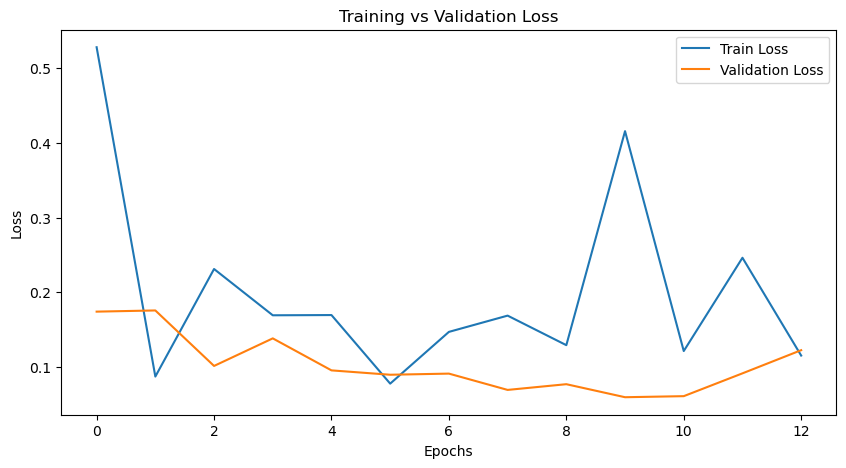

In [75]:
# Plot training & validation loss

plt.figure(figsize=(10,5))
plt.plot(history_InceptionV3.history['loss'], label='Train Loss')
plt.plot(history_InceptionV3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [77]:
test_gen_InceptionV3 = ImageDataGenerator(rescale=1./255)

In [79]:
test_iter_InceptionV3 = test_gen_InceptionV3.flow_from_directory(
    test_path,
    target_size=(224, 224),
    class_mode=None,   # because no labels in test set
    shuffle=False,     # keeps order so predictions map to filenames
    batch_size=32
)


Found 3187 images belonging to 11 classes.


In [81]:
# Predictions
y_pred = model_InceptionV3.predict(test_iter_InceptionV3)

# Convert probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels from the generator
y_true = test_iter_InceptionV3.classes

C:\Users\vnave\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 275s 3s/step


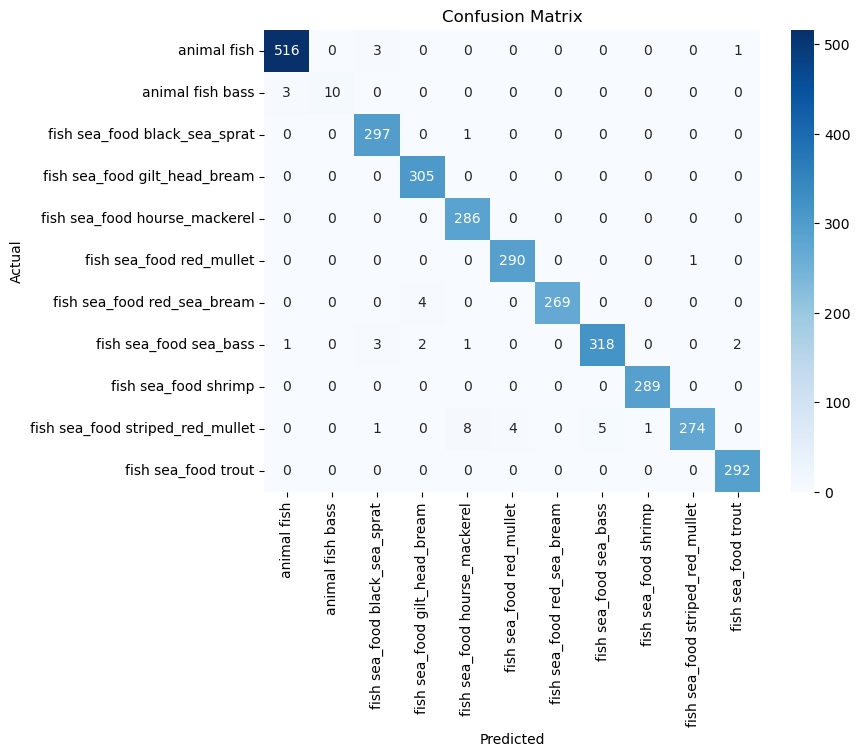

In [83]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_iter_InceptionV3.class_indices.keys(),
            yticklabels=test_iter_InceptionV3.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [85]:
report = classification_report(y_true, y_pred_classes,
                               target_names=test_iter_InceptionV3.class_indices.keys())
print(report)


                                  precision    recall  f1-score   support

                     animal fish       0.99      0.99      0.99       520
                animal fish bass       1.00      0.77      0.87        13
   fish sea_food black_sea_sprat       0.98      1.00      0.99       298
   fish sea_food gilt_head_bream       0.98      1.00      0.99       305
   fish sea_food hourse_mackerel       0.97      1.00      0.98       286
        fish sea_food red_mullet       0.99      1.00      0.99       291
     fish sea_food red_sea_bream       1.00      0.99      0.99       273
          fish sea_food sea_bass       0.98      0.97      0.98       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       1.00      0.94      0.96       293
             fish sea_food trout       0.99      1.00      0.99       292

                        accuracy                           0.99      3187
                       macro avg    

In [87]:
#Save the MobileNet Model .h5 file format 

model_InceptionV3.save("InceptionV3_Model.h5")

In [ ]:
#Apply the pre-trained model "EfficientNetB0" 

In [15]:
from tensorflow.keras.applications import EfficientNetB0

In [19]:
# building our model using pre-trained Model "MobileNet"

base_model_EfficientNetB0 = EfficientNetB0(
    include_top=False,# Customize the output layers for your specific classification task.
    weights='imagenet',#Loads weights from a model trained on the large ImageNet dataset.
    input_shape=(224,224,3)
)

base_model_EfficientNetB0.trainable = False # freeze the base model

model_EfficientNetB0 = tf.keras.Sequential([
    base_model_EfficientNetB0,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax')
])

In [21]:
# compile the model

model_EfficientNetB0.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
model_EfficientNetB0.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 1280)          │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,876,206 (18.60 MB)

 Trainable params: 824,075 (3.14 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [25]:
# defining call backs to preserve the best result
#Overfiting 

early_EfficientNetB0  = tf.keras.callbacks.EarlyStopping(patience = 3,min_delta = 0.001,restore_best_weights = True)

In [27]:
# train the model

batch_size = 32

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

In [29]:
# fit the model

history_EfficientNetB0 = model_EfficientNetB0.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=50,
    callbacks=[early_EfficientNetB0]
)                                                                                                                                                                                                                       

C:\Users\vnave\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - accuracy: 0.1441 - loss: 2.3706 - val_accuracy: 0.1785 - val_loss: 2.3119
Epoch 2/50
  1/155 ━━━━━━━━━━━━━━━━━━━━ 2:43 1s/step - accuracy: 0.0625 - loss: 2.3642

C:\Users\vnave\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


155/155 ━━━━━━━━━━━━━━━━━━━━ 65s 414ms/step - accuracy: 0.0625 - loss: 2.3642 - val_accuracy: 0.1776 - val_loss: 2.3124
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.1747 - loss: 2.3197 - val_accuracy: 0.1752 - val_loss: 2.3282
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 69s 438ms/step - accuracy: 0.2188 - loss: 2.2628 - val_accuracy: 0.1752 - val_loss: 2.3274


In [31]:
#store results

acc = history_EfficientNetB0.history['accuracy']
val_acc = history_EfficientNetB0.history['val_accuracy']
loss = history_EfficientNetB0.history['loss']
val_loss = history_EfficientNetB0.history['val_loss']


In [33]:
# evalutae the accuracy of the model and Loss

accuracy_score = model_EfficientNetB0.evaluate(validation_generator)
print(accuracy_score)
print('Accuracy : {:.2f}%'.format(accuracy_score[1]*100))
#Converts the accuracy value to a percentage and prints it to two decimal places.
print('Loss:',accuracy_score[0])

# accuracy_score[0] will hold the loss value.
# accuracy_score[1] will hold the accuracy value.

39/39 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.1909 - loss: 2.3070
[2.3125433921813965, 0.1764705926179886]
Accuracy : 17.65%
Loss: 2.3125433921813965


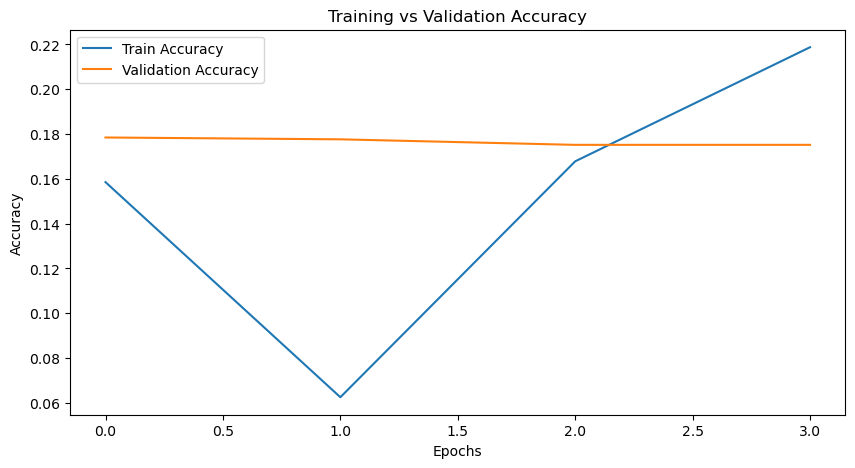

In [35]:
# Plot training & validation accuracy

plt.figure(figsize=(10,5))
plt.plot(history_EfficientNetB0.history['accuracy'], label='Train Accuracy')
plt.plot(history_EfficientNetB0.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

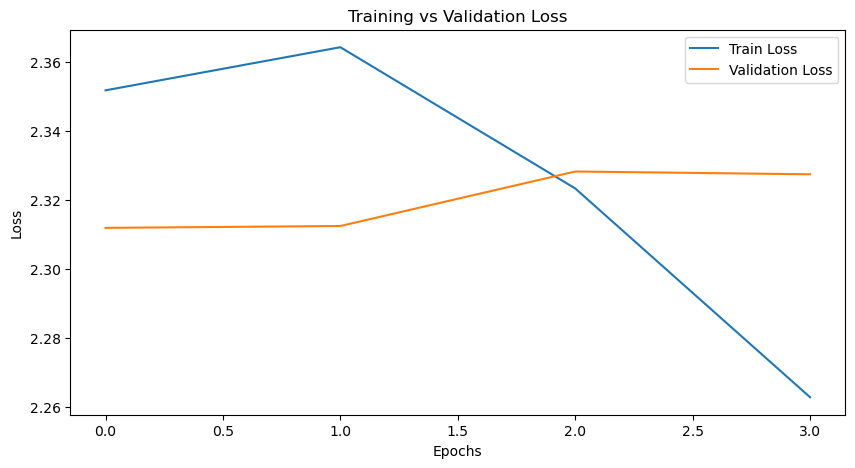

In [37]:
# Plot training & validation loss

plt.figure(figsize=(10,5))
plt.plot(history_EfficientNetB0.history['loss'], label='Train Loss')
plt.plot(history_EfficientNetB0.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [39]:
test_gen_EfficientNetB0 = ImageDataGenerator(rescale=1./255)

In [41]:
test_iter_EfficientNetB0 = test_gen_EfficientNetB0.flow_from_directory(
    test_path,
    target_size=(224, 224),
    class_mode=None,   # because no labels in test set
    shuffle=False,     # keeps order so predictions map to filenames
    batch_size=32
)


Found 3187 images belonging to 11 classes.


In [43]:
# Predictions
y_pred = model_EfficientNetB0.predict(test_iter_EfficientNetB0)

# Convert probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels from the generator
y_true = test_iter_EfficientNetB0.classes

100/100 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step


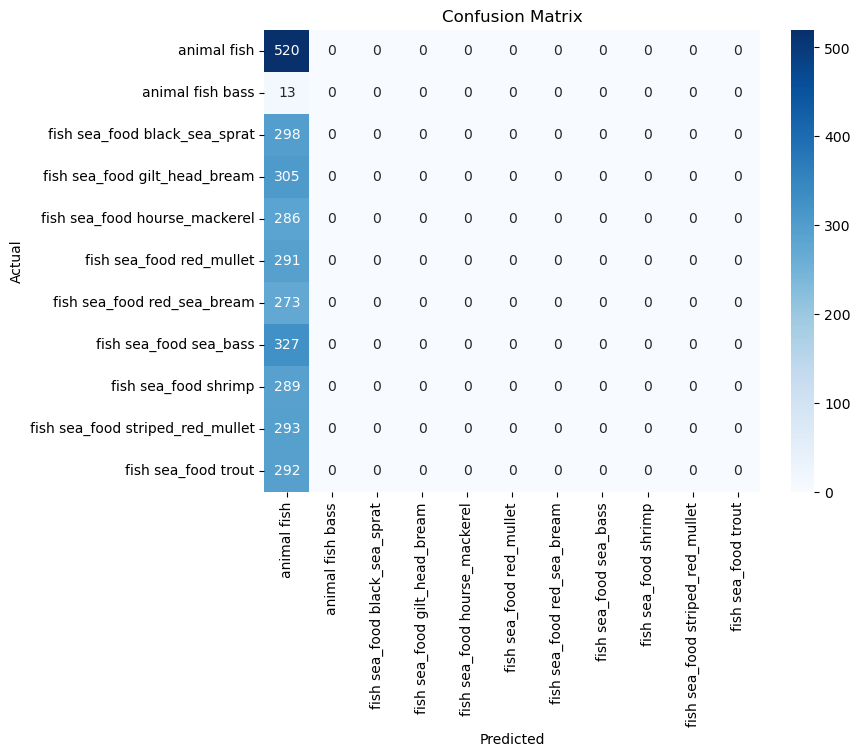

In [45]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_iter_EfficientNetB0.class_indices.keys(),
            yticklabels=test_iter_EfficientNetB0.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [47]:
report = classification_report(y_true, y_pred_classes,
                               target_names=test_iter_EfficientNetB0.class_indices.keys())
print(report)


                                  precision    recall  f1-score   support

                     animal fish       0.16      1.00      0.28       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.00      0.00      0.00       298
   fish sea_food gilt_head_bream       0.00      0.00      0.00       305
   fish sea_food hourse_mackerel       0.00      0.00      0.00       286
        fish sea_food red_mullet       0.00      0.00      0.00       291
     fish sea_food red_sea_bream       0.00      0.00      0.00       273
          fish sea_food sea_bass       0.00      0.00      0.00       327
            fish sea_food shrimp       0.00      0.00      0.00       289
fish sea_food striped_red_mullet       0.00      0.00      0.00       293
             fish sea_food trout       0.00      0.00      0.00       292

                        accuracy                           0.16      3187
                       macro avg    

C:\Users\vnave\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vnave\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vnave\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#The Final MobileNet pre-trained model Got the Best Accuracy : 99.03% and Loss: 0.0209
#MobileNet Model was Best Performance 
#so i did choose the MobileNet Model Apply to predict the fish Category 

In [2]:
import tensorflow as tf
print(tf.__version__)


2.20.0
